In [1]:
#Singular Spectrum Analysis (SSA) of Exoplanetary Transits

%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib import rc
import numpy as np
import pandas as pd
import lightkurve as lk

def SSA(L,y):
    N = len(y)
    Init_TS = pd.Series(y)
    K = N-L+1
    
    #The Trajectory Matrix:
    X = np.array([Init_TS.values[i:L+i] for i in range(0,K)]).T
    
    #The Singular Vlaue Decomposition (Left and Right Singular Vectors and the Singular Values Matrix):
    U, Sigma, VT = np.linalg.svd(X)
    
    #Rak of the Trajectory Matrix:
    d = np.linalg.matrix_rank(X)  
    
    #Component Time Series:
    Component_TS = np.zeros((N, d))        
    for i in range(d):
        elements = Sigma[i]*np.outer(U[:,i], VT[i,:])
        rev = elements[::-1]
        Component_TS[:,i] = [rev.diagonal(j).mean() for j in range(-rev.shape[0]+1, rev.shape[1])]
        
    #Weights of the W_Correlation Matrix:    
    w = np.array(list(np.arange(L)+1) + [L]*(K-L-1) + list(np.arange(L)+1)[::-1])  
    
    #The W_Correlation Matrix:
    def w_inner(P_i, P_j):       
        return w.dot(P_i*P_j)
    w_norms = np.array([w_inner(Component_TS[:,i], Component_TS[:,i]) for i in range(d)])
    w_norms = w_norms**-0.5
    W_Corr = np.identity(d)
    for i in range(d):
        for j in range(i+1,d):
            W_Corr[i,j] = abs(w_inner(Component_TS[:,i], Component_TS[:,j]) * w_norms[i] * w_norms[j])
            W_Corr[j,i] = W_Corr[i,j] 
    return W_Corr, Component_TS

#Reconstructing a New Time Series From SSA Components
def reconstruct(y, Component_TS, indices):
    Init_TS = pd.Series(y)
    New_vals = Component_TS[:,indices].sum(axis=1)
    return pd.Series(New_vals, index=Init_TS.index)

#Running Mean for Calculating the Sigma_{CDPP}:
def running_mean(data, window_size):
    if window_size > len(data):
        window_size = len(data)
    cumsum = np.cumsum(np.insert(data, 0, 0))
    return (cumsum[window_size:] - cumsum[:-window_size]) / float(window_size) 

<Axes: xlabel='Time - 2457000 [BTJD days]', ylabel='Flux [$\\mathrm{e^{-}\\,s^{-1}}$]'>

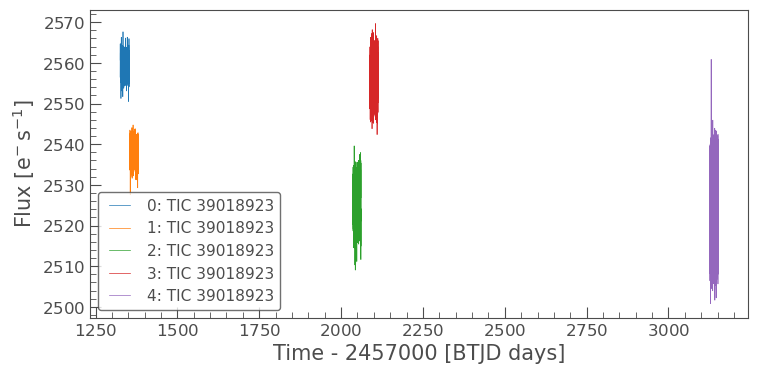

In [23]:
#Searching and Downloading the Photometry Data from TESS:

search_result = lk.search_lightcurve('TIC 39018923', mission='Tess',author="TESS-SPOC")
lc_collection = search_result.download_all(flux_column='pdcsap_flux')
lc_collection.plot()

In [24]:
#Removing the Outliers and NaN Values:

for i in range(len(lc_collection)):
    #lc_collection[i] = lc_collection[i].remove_outliers(sigma=5)
    lc_collection[i]= lc_collection[i].remove_nans()

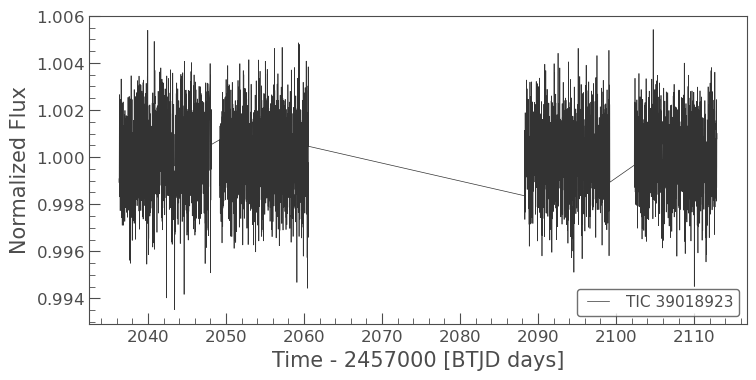

In [25]:
#Stitch and Flatten the Time Series:

lc = lc_collection[2,3].stitch().flatten(window_length=901)
lc.plot();

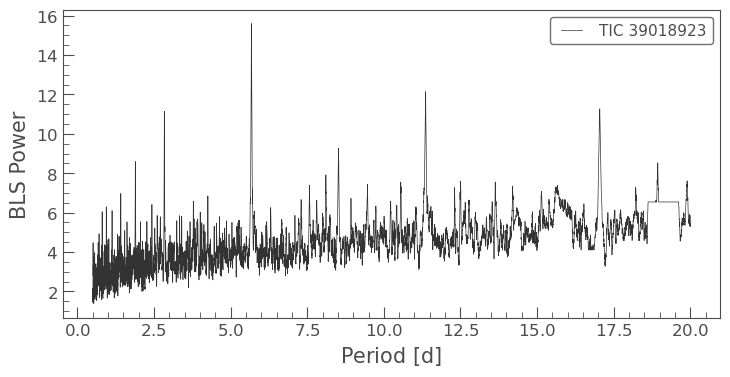

In [26]:
# Create array of periods to search for Transits
period = np.linspace(0.5, 20, 10000)

# Create a BLSPeriodogram
bls = lc.to_periodogram(method='bls', period=period, frequency_factor=500,objective='snr');
bls.plot();

In [27]:
planet_period = bls.period_at_max_power
Transit_t0 = bls.transit_time_at_max_power
Transit_dur = bls.duration_at_max_power
Transit_Depth= bls.depth_at_max_power*10**(6)  #Transit Depth [PPM]

print(planet_period)
print(Transit_Depth)

5.67971797179718 d
1815.1681996984635


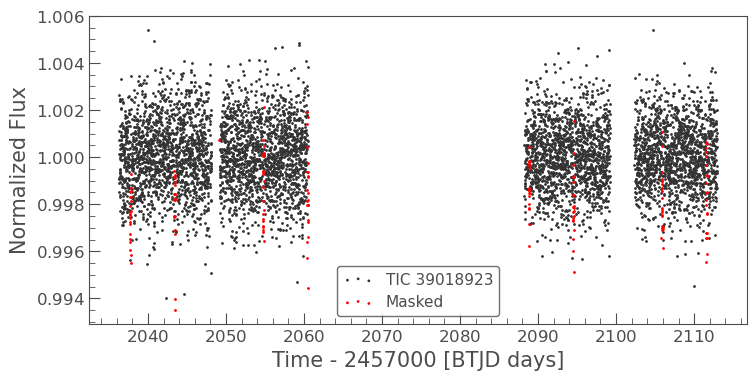

In [28]:
# Create a cadence mask using the BLS parameters
planet_mask = bls.get_transit_mask(period=planet_period,
                                     transit_time=Transit_t0,
                                     duration=Transit_dur)
lc = lc[~np.isnan(lc['flux'])]
masked_lc = lc[~planet_mask]
ax = masked_lc.scatter();
lc[planet_mask].scatter(ax=ax, c='r', label='Masked');

(-2.0, 2.0)

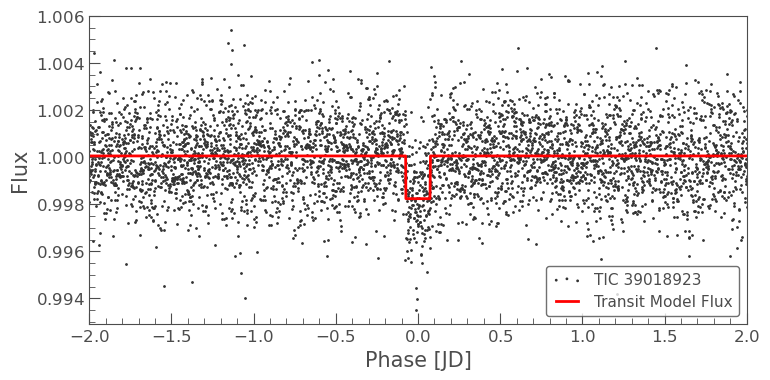

In [29]:
# Create a BLS model using the BLS parameters
planet_model = bls.get_transit_model(period=planet_period,
                                       transit_time=Transit_t0,
                                       duration=Transit_dur)
folded_lc = lc.fold(period=planet_period, epoch_time=Transit_t0)
ax =folded_lc.scatter();
planet_model.fold(planet_period*1, Transit_t0).plot(ax=ax, c='r', lw=2)
ax.set_xlim(-2, 2)

In [30]:
#Calculating the Sigma_{CDPP} (Before SSA):

detrended_lc = lc.flatten(window_length=101, polyorder=2)
normalized_lc = detrended_lc.normalize("ppm")
mean=running_mean(data=normalized_lc.flux, window_size=13)
Sigma_c=np.std(mean)

print(Sigma_c)

394.6115382105378 ppm


In [31]:
#Calculating the Transit SNR (Before SSA):

N=8 #Number of Transits
SNR_1=np.sqrt(N)*Transit_Depth/Sigma_c
print(SNR_1)

13.010443119036864 1 / ppm


In [32]:
# Storing the Time Series Data for SSA:

x=np.array(lc.time.to_value(format='btjd'))
y=np.array(lc['flux'])

In [33]:
#Performing SSA and getting the W_Correlation Matrix and Component Time Series:

W_Matrix, P_ssa = SSA(100,y)

Text(0, 0.5, '$\\tilde p_j$')

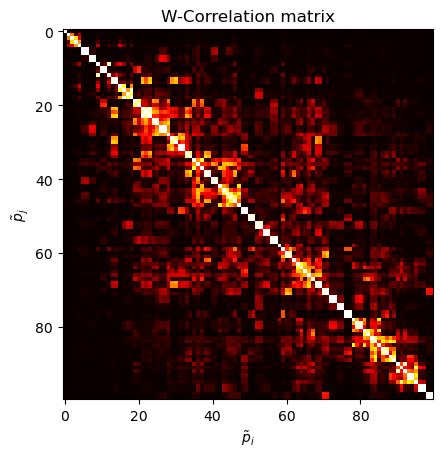

In [34]:
plt.imshow(W_Matrix,cmap='hot')
plt.title("W-Correlation matrix")
plt.xlabel(r"$\tilde p_i$")
plt.ylabel(r"$\tilde p_j$")

In [35]:
#Reconstructing a new Time Series based on the indices of the selected Components: 

index=[]
for i in range (100):
    N=0
    for j in range (100):
        if W_Matrix[i,j]>0.2 and i!=j:
            N=N+1
    if N<5:
        index.append(i)

SSA_lc = lc.copy()
x2=[]
ind=[]
import math as m
for i in range (len(x)):
    if not m.isnan(y[i]):
        x2.append(x[i])
        ind.append(i)

SSA_lc.flux[ind]=np.array(reconstruct(y, P_ssa , index))

In [36]:
#After SSA:

period = np.linspace(0.5, 20, 10000)
bls = SSA_lc.to_periodogram(method='bls', period=period, frequency_factor=500,objective='snr');
planet_period = bls.period_at_max_power
Transit_t0 = bls.transit_time_at_max_power
Transit_dur = bls.duration_at_max_power
Transit_Depth= bls.depth_at_max_power*10**(6)  #Transit Depth [PPM]

print(Transit_Depth)

1447.006811058545


(-2.0, 2.0)

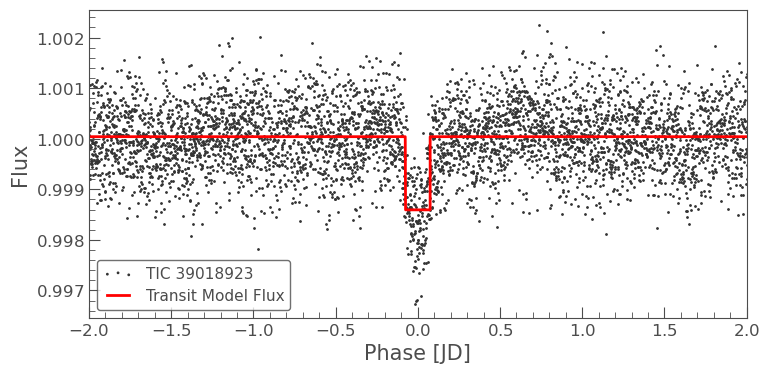

In [37]:
# Create a BLS model using the BLS parameters
planet_model = bls.get_transit_model(period=planet_period,
                                       transit_time=Transit_t0,
                                       duration=Transit_dur)
folded_lc = SSA_lc.fold(period=planet_period, epoch_time=Transit_t0)
ax =folded_lc.scatter();
planet_model.fold(planet_period*1, Transit_t0).plot(ax=ax, c='r', lw=2)
ax.set_xlim(-2, 2)

In [38]:
#Calculating the Sigma_{CDPP} (After SSA):

detrended_lc = SSA_lc.flatten(window_length=101, polyorder=2)
normalized_lc = detrended_lc.normalize("ppm")
mean=running_mean(data=normalized_lc.flux, window_size=13)
Sigma_c=np.std(mean)

print(Sigma_c)

279.237002356508 ppm


In [40]:
#Calculating the Transit SNR (After SSA):

N=8 #Number of Transits
SNR_2=np.sqrt(N)*Transit_Depth/Sigma_c
print(SNR_2)

14.65691609475583 1 / ppm
